In [1]:
from ete3 import Tree, TreeStyle, PieChartFace,NodeStyle
import seaborn as sns
import os
import numpy as np
from Bio import SeqIO
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook

## This example shows a custom data analysis (i.e. one that can't be carried out using methods
## I included in pyparanoid.genomeplot).

In [2]:
### this can be any tree as long as leaves are labeled with the name of the strain used by PyParanoid
tree = Tree("exp_strains.rerooted.tre")
strains = tree.get_leaf_names()

In [3]:
### specify the path to the 'homolog_matrix' file in your PyParanoid output directory
matrixfile = open("../data/Pseudo/homolog_matrix.txt",'r')
header = matrixfile.readline().rstrip().split("\t")
indices = [header.index(s) for s in strains]

In [4]:
lines = []
for line in matrixfile:
    vals = line.rstrip().split("\t")
    lines.append([int(bool(int(vals[i]))) for i in indices])
a = np.stack(lines)

In [5]:
# Get the number of genes in each genome
genome_sizes = {}
for s in strains:
    count = 0
    ### path to your genomedb folder
    for seq in SeqIO.parse(open("../data/genomedb/pep/{}.pep.fa".format(s),'r'),'fasta'):
        count += 1
    genome_sizes[s] = count

In [6]:
def add_piecharts(node,nstyle,strains,a,genome_sizes,pal):
	node_strains = node.get_leaf_names()
	node.set_style(nstyle)
	if len(node_strains) > 1:
		col_indices = [strains.index(ns) for ns in node_strains]
		orth_count = 0
		for i in range(a.shape[0]):
			if np.count_nonzero(a[i,col_indices]) == len(col_indices):
				orth_count += 1
		frac = float(orth_count)/float(sum([genome_sizes[ns] for ns in node_strains])/len(node_strains))
        ### Change the following line for scaling the pie chart size
		size = math.sqrt(len(node_strains)) * 7
		f = PieChartFace([frac*100,100-(frac*100)],size,size,colors=[colors.rgb2hex(c) for c in [pal[0],pal[7]]])
		node.add_face(f,0)
	return

In [7]:
pal = sns.color_palette("Set2",10)
nstyle = NodeStyle()
nstyle["size"] = 0
for node in tree.iter_descendants("preorder"):
    add_piecharts(node,nstyle,strains,a,genome_sizes,pal)
add_piecharts(tree,nstyle,strains,a,genome_sizes,pal)

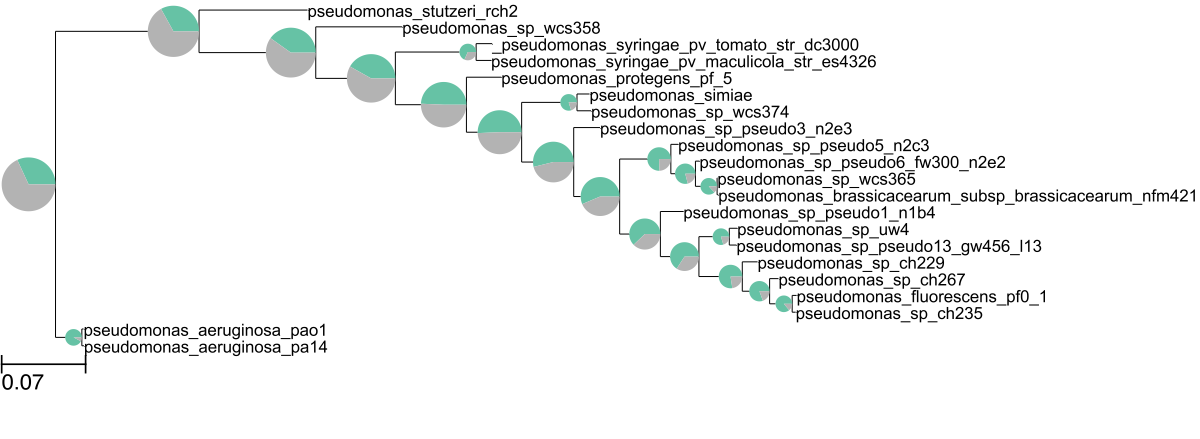

In [8]:
## in this example, the pie chart at each node represents the fraction of the genome shared by the entire clade
## green indicates conserved, gray indicates variable
## e.g. Pseudomonas CH229, CH267, Pf0-1, and CH235 share ~75% of their genomes
tree.render('%%inline',w=1200)

In [9]:
## These names are pretty ugly so let's clean em up
## This is a tab delimited file that translates the PyParanoid strain names to something readable.
!head renamed_list.txt

pseudomonas_protegens_pf_5	Pseudomonas protegens Pf-5
pseudomonas_sp_ch235	Pseudomonas sp. CH235
pseudomonas_brassicacearum_subsp_brassicacearum_nfm421	Pseudomonas brassicacearum NFM421
pseudomonas_aeruginosa_pao1	Pseudomonas aeruginosa PAO1
pseudomonas_aeruginosa_pa14	Pseudomonas aeruginosa PA14
_pseudomonas_syringae_pv_tomato_str_dc3000	 Pseudomonas syringae DC3000
pseudomonas_sp_ch229	Pseudomonas sp. CH229
pseudomonas_sp_uw4	Pseudomonas sp. UW4
pseudomonas_simiae	Pseudomonas simiae WCS417
pseudomonas_sp_ch255	Pseudomonas sp. CH255


In [10]:
## Replace the names of the nodes with the new ones.
namedict = {l[0] : l[1] for l in [line.rstrip().split("\t") for line in open("renamed_list.txt",'r').readlines()]}
for node in tree.iter_descendants("preorder"):
    if node.is_leaf():
        node.name = namedict[node.name]

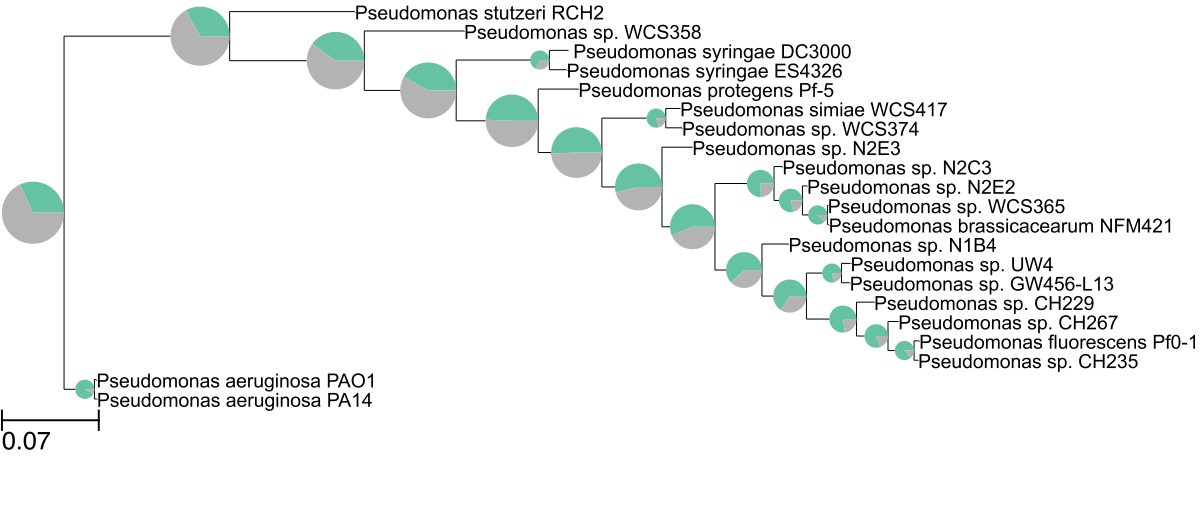

In [11]:
tree.render('%%inline',w=1200)

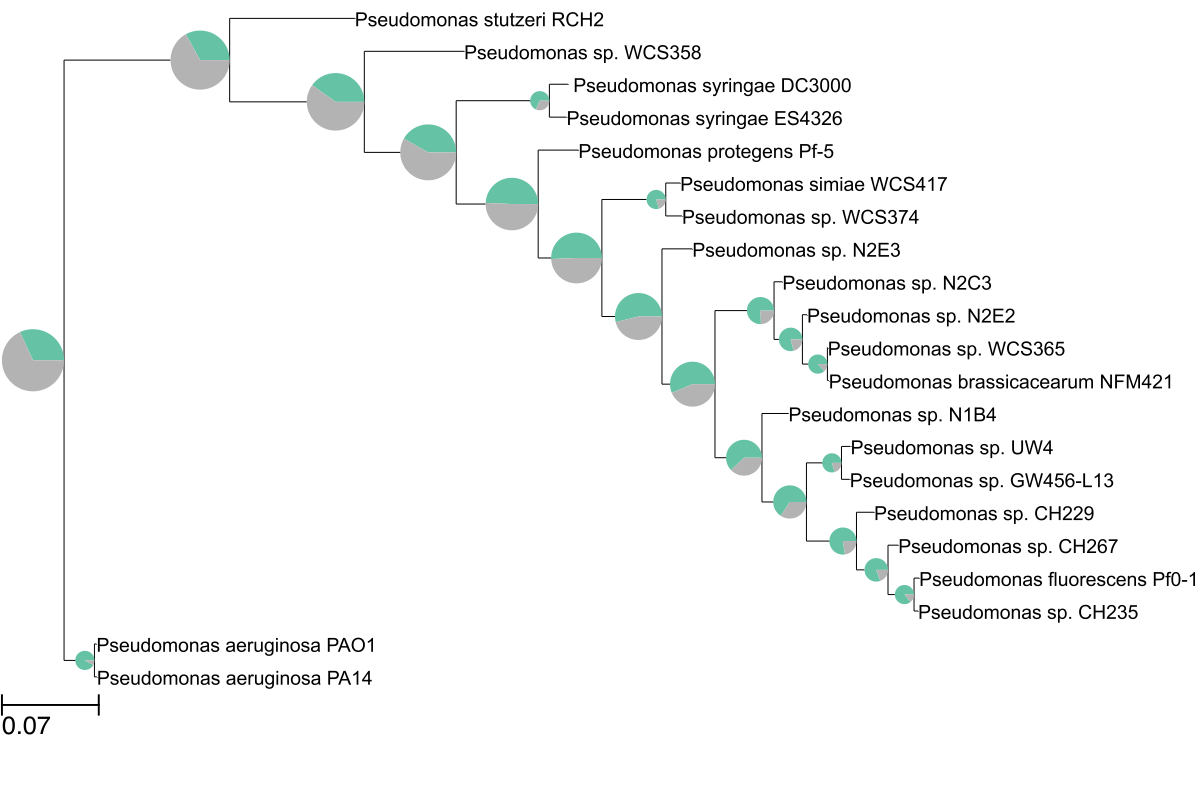

In [12]:
## Space out the leaves a bit for readability.
ts = TreeStyle()
ts.branch_vertical_margin = 7
tree.render('%%inline',w=1200,tree_style=ts)

In [13]:
tree.render("Pseudo_PieChartTree.pdf",tree_style=ts,h=96,units="in")
pass